In [1]:
import os
import time
from pathlib import Path
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import sys
sys.path.append("src")

from dataset import PeptideDataset
from model import RetentionPredictor
from utils import evaluate_regression_metrics
from train_cmaes import train_cmaes_1_1
from train_de import train_de
from train_adam import train_adam

In [2]:
BATCH_SIZE = int(os.getenv("BATCH_SIZE"))
SEED = int(os.getenv("RANDOM_SEED"))
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
sns.set_theme(style="whitegrid")

In [4]:
HIDDEN_SIZES = [32, 16]
RANDOM_SEED = 123
BATCH_SIZE = 32

#DATASETS = ["../data/krokhin.txt", "../data/mouse.txt" "../data/petritis.txt", "../data/serum.txt"]

ADAM_CONFIG = {"epochs": 150, "lr": 3e-4}
CMAES_CONFIG = {"generations": 400}
DE_CONFIG = {"generations": 400}

In [5]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)

In [6]:
def load_data(path):
    sequences, retention_times = [], []
    with open(path) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                seq, rt = parts
                sequences.append(seq)
                retention_times.append(float(rt))
    dataset = PeptideDataset(sequences, retention_times)
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, val_size])

In [7]:
def run_experiment(algorithm, dataset_path, config):
    set_seed(RANDOM_SEED)
    train_data, val_data = load_data(dataset_path)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

    model = RetentionPredictor()
    criterion = nn.SmoothL1Loss()

    start = time.time()

    if algorithm == "adam":
        model, history = train_adam(model, criterion, train_loader, val_loader, **config)
    elif algorithm == "cmaes":
        model, history = train_cmaes_1_1(model, criterion, train_loader, val_loader, **config)
    elif algorithm == "de":
        model, history = train_de(model, criterion, train_loader, val_loader, **config)
    else:
        raise ValueError("Unknown algorithm")

    elapsed = time.time() - start
    metrics = evaluate_regression_metrics(model, val_loader)

    return {
        "algorithm": algorithm,
        "dataset_name": os.path.basename(dataset_path),
        "history": history,
        "final_metrics": {
            **metrics,
            "train_loss": history["train_loss"][-1],
            "val_loss": history["val_loss"][-1],
            "eval_calls": history["eval_calls"],
            "train_time": elapsed
        }
    }

In [8]:
def plot_learning_curves(history, label):
    plt.plot(history["generation"], history["train_loss"], label=f"Train - {label}")
    plt.plot(history["generation"], history["val_loss"], label=f"Val - {label}")
    plt.xlabel("Generation")
    plt.ylabel("Loss")
    plt.legend()

In [9]:
def summarize_results(res):
    print("\n\nFinal Metrics Summary:")
    print("="*40)
    print(f"{res['algorithm'].upper()} | Dataset: {res['dataset_name']} | Val R2: {res['final_metrics']['r2']:.3f} | MAE: {res['final_metrics']['mae']:.4f} | Eval Calls: {res['final_metrics']['eval_calls']} | Time: {res['final_metrics']['train_time']:.2f}s")


===== Dataset: data/krokhin.txt =====
Running ADAM...
Epoch   1/150 | Train Loss: 0.07396 | Val Loss: 0.07326
Epoch   2/150 | Train Loss: 0.04961 | Val Loss: 0.05050
Epoch   3/150 | Train Loss: 0.03556 | Val Loss: 0.03431
Epoch   4/150 | Train Loss: 0.02514 | Val Loss: 0.02367
Epoch   5/150 | Train Loss: 0.01969 | Val Loss: 0.01727
Epoch   6/150 | Train Loss: 0.01579 | Val Loss: 0.01378
Epoch   7/150 | Train Loss: 0.01277 | Val Loss: 0.01151
Epoch   8/150 | Train Loss: 0.01086 | Val Loss: 0.01009
Epoch   9/150 | Train Loss: 0.00908 | Val Loss: 0.00911
Epoch  10/150 | Train Loss: 0.00762 | Val Loss: 0.00837
Epoch  11/150 | Train Loss: 0.00680 | Val Loss: 0.00764
Epoch  12/150 | Train Loss: 0.00590 | Val Loss: 0.00711
Epoch  13/150 | Train Loss: 0.00547 | Val Loss: 0.00667
Epoch  14/150 | Train Loss: 0.00503 | Val Loss: 0.00633
Epoch  15/150 | Train Loss: 0.00470 | Val Loss: 0.00603
Epoch  16/150 | Train Loss: 0.00451 | Val Loss: 0.00576
Epoch  17/150 | Train Loss: 0.00411 | Val Loss: 0

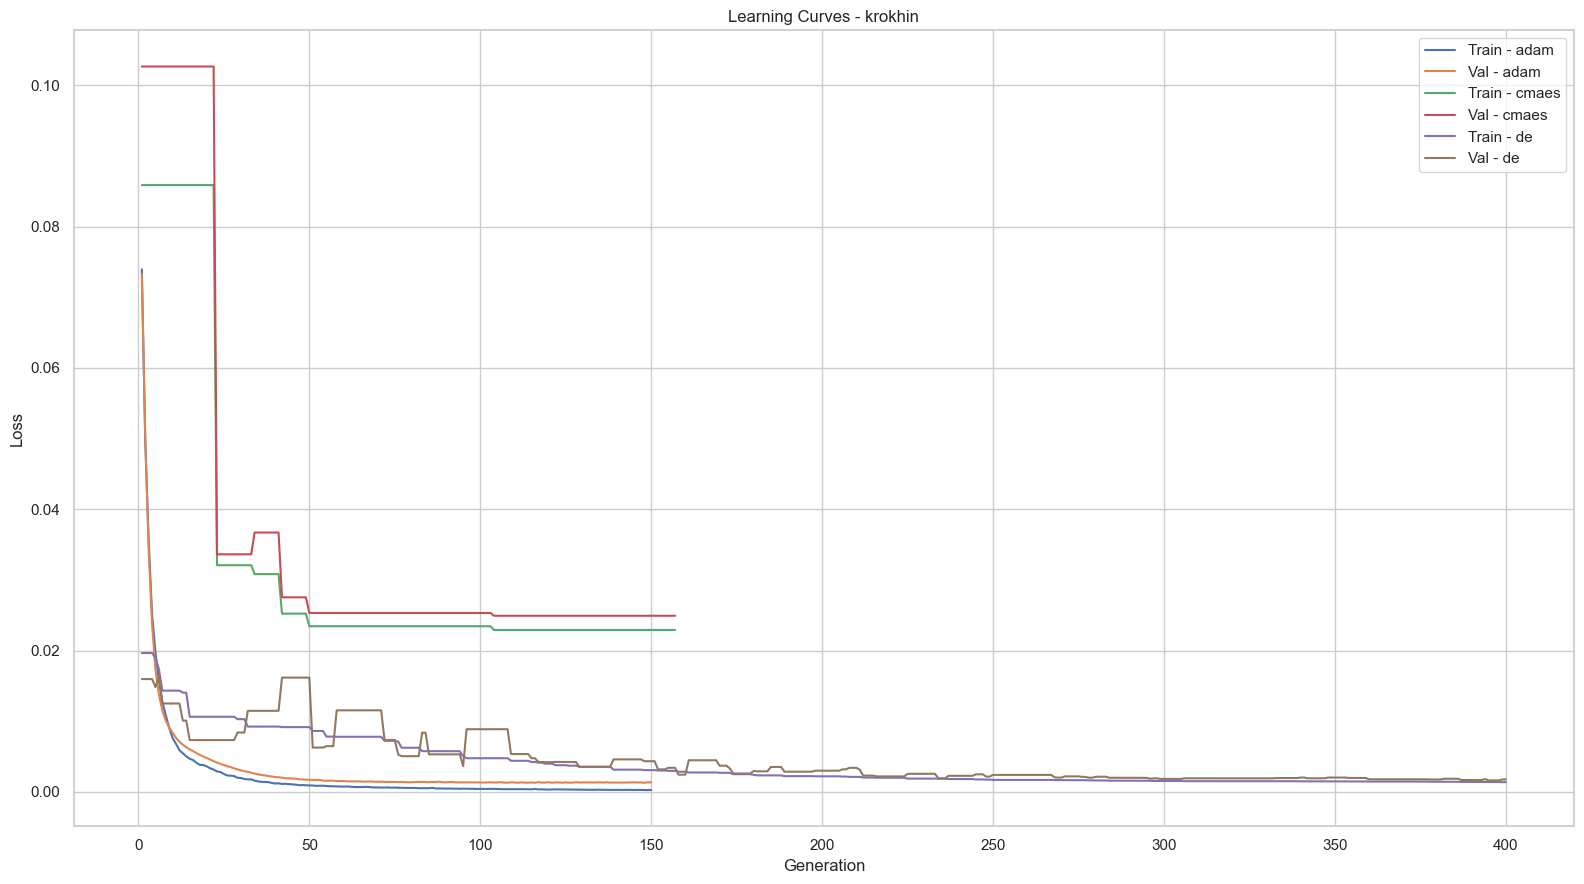

In [10]:
all_results = []
dataset_path = "data/krokhin.txt"
plt.figure(figsize=(16,9))
print(f"\n===== Dataset: {dataset_path} =====")
for alg, cfg in zip(["adam", "cmaes", "de"], [ADAM_CONFIG, CMAES_CONFIG, DE_CONFIG]):
    print(f"Running {alg.upper()}...")
    result = run_experiment(alg, dataset_path, cfg)
    summarize_results(result)
    all_results.append(result)
    plot_learning_curves(result["history"], label=alg)

plt.title(f"Learning Curves - {Path(dataset_path).stem}")
plt.tight_layout()
plt.savefig(f'results/curves_{Path(dataset_path).stem}.png')
plt.show()

In [ ]:
dataset_path = "data/mouse.txt"
plt.figure(figsize=(16,9))
print(f"\n===== Dataset: {dataset_path} =====")
for alg, cfg in zip(["adam", "cmaes", "de"], [ADAM_CONFIG, CMAES_CONFIG, DE_CONFIG]):
    print(f"Running {alg.upper()}...")
    result = run_experiment(alg, dataset_path, cfg)
    summarize_results(result)
    all_results.append(result)
    plot_learning_curves(result["history"], label=alg)

plt.title("Learning Curves")
plt.tight_layout()
plt.savefig(f'results/curves_{Path(dataset_path).stem}.png')
plt.show()


===== Dataset: data/mouse.txt =====
Running ADAM...
Epoch   1/150 | Train Loss: 0.05592 | Val Loss: 0.02283
Epoch   2/150 | Train Loss: 0.01350 | Val Loss: 0.00813
Epoch   3/150 | Train Loss: 0.00592 | Val Loss: 0.00579
Epoch   4/150 | Train Loss: 0.00452 | Val Loss: 0.00505
Epoch   5/150 | Train Loss: 0.00397 | Val Loss: 0.00466
Epoch   6/150 | Train Loss: 0.00365 | Val Loss: 0.00428
Epoch   7/150 | Train Loss: 0.00338 | Val Loss: 0.00405
Epoch   8/150 | Train Loss: 0.00317 | Val Loss: 0.00398
Epoch   9/150 | Train Loss: 0.00303 | Val Loss: 0.00374
Epoch  10/150 | Train Loss: 0.00290 | Val Loss: 0.00363
Epoch  11/150 | Train Loss: 0.00281 | Val Loss: 0.00356
Epoch  12/150 | Train Loss: 0.00269 | Val Loss: 0.00344
Epoch  13/150 | Train Loss: 0.00263 | Val Loss: 0.00342
Epoch  14/150 | Train Loss: 0.00259 | Val Loss: 0.00332
Epoch  15/150 | Train Loss: 0.00256 | Val Loss: 0.00362
Epoch  16/150 | Train Loss: 0.00251 | Val Loss: 0.00325
Epoch  17/150 | Train Loss: 0.00243 | Val Loss: 0.0

In [ ]:
for res in all_results:
    summarize_results(res)